# Channel & Feature Importances For Hand-crafted features

In this tutorial, we show how to find channel and feature importances, using hand-crafted features on MedNIST data. First, let's download the data

In [1]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
data_dir = './jurkat/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))

    
num_total = len(image_label_list)
image_width, image_height, channels = imread(image_file_list[0]).shape

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height, "x", channels)
print("Label names:", class_names)



Total image count: 95
Image dimensions: 66 x 66 x 3
Label names: ['Metaphase', 'Telophase']


In [13]:
(np.array(image_label_list) == 1).sum()

27

## Visualize randomly chosen pitures

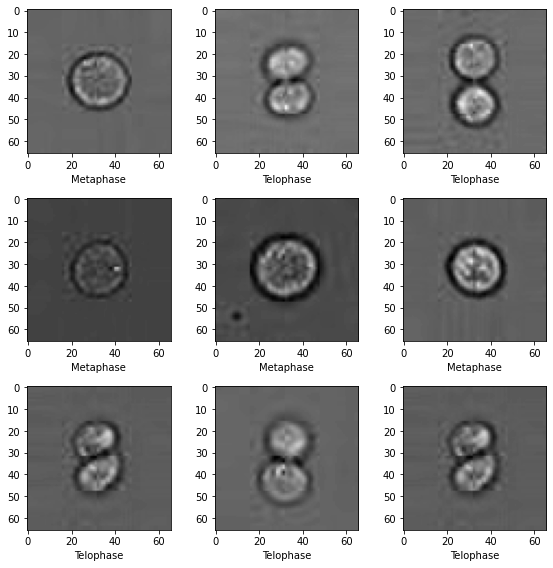

In [3]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = imread(image_file_list[k])[:,:,2]
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

as we see, we only have information in the Red channel, but green & blue are only noise.

In [4]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.spatial import distance as dist
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from skimage.exposure import histogram
from skimage.measure import shannon_entropy
from skimage.measure import moments_hu, inertia_tensor, inertia_tensor_eigvals
from skimage.measure import moments
from skimage.feature import hog
from skimage.transform import resize


def basic_statistical_features(image):
    """calculates the set of basic statistical features 
    
    Calculates the standard statistical features per channel every 10th percentile,
    sum of the pixel values and different moments

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels.

    Returns
    -------
    features :  dict  
        dictionary including percentiles, moments and sum per channel 

    """
    # storing the feature values
    features = dict()
    for ch in range(image.shape[2]):
        # percentiles
        features["min_intensity_Ch" + str(ch+1)] = image[:,:,ch].min()
        features["percentile10_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 10)
        features["percentile20_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 20)
        features["percentile30_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 30)
        features["percentile40_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 40)
        features["percentile50_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 50)
        features["percentile60_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 60)
        features["percentile70_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 70)
        features["percentile80_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 80)
        features["percentile90_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 90)
        features["max_intensity_Ch" + str(ch+1)] = image[:,:,ch].max()

        # pixel sum
        features["total_intensity_Ch" + str(ch+1)] = image[:,:,ch].sum()

        # moments
        features["mean_intensity_Ch" + str(ch+1)] = image[:,:,ch].mean()
        features["std_intensity_Ch" + str(ch+1)] = image[:,:,ch].std()
        features["kurtosis_intensity_Ch" + str(ch+1)] = kurtosis(image[:,:,ch].ravel()) 
        features["skew_intensity_Ch" + str(ch+1)] = skew(image[:,:,ch].ravel()) 

        features["shannon_entropy_Ch" + str(ch+1)] = shannon_entropy(image[:,:,ch])
    
    return features




def glcm_features(image):
    """calculates the glcm features 
    
    Calculates the features per channel using glcm features including
    contrast, dissimilarity, homogeneity, ASM, energy and correlation.
    For more info please refer to:
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels. 

    Returns
    -------
    features :  dict  
        dictionary including 'contrast_Chx', 'dissimilarity_Chx', 'homogeneity_Chx'
        'ASM_Chx', 'energy_Chx' and 'correlation_Chx' per channel where 
        x will be substituted by the channel number starting from 1. 

    """
    features = dict()
    for ch in range(image.shape[2]):
        # create a 2D temp image 
        temp_image = image[:,:,ch].copy()
        temp_image = (temp_image/temp_image.max())*255 # use 8bit pixel values for GLCM
        temp_image = temp_image.astype('uint8') # convert to unsigned for GLCM

        # calculating glcm
        glcm = greycomatrix(temp_image,distances=[5],angles=[0],levels=256)

        # storing the glcm values
        features["contrast_Ch" + str(ch+1)] = greycoprops(glcm, prop='contrast')[0,0]
        features["dissimilarity_Ch" + str(ch+1)] = greycoprops(glcm, prop='dissimilarity')[0,0]
        features["homogeneity_Ch" + str(ch+1)] = greycoprops(glcm, prop='homogeneity')[0,0]
        features["ASM_Ch" + str(ch+1)] = greycoprops(glcm, prop='ASM')[0,0]
        features["energy_Ch" + str(ch+1)] = greycoprops(glcm, prop='energy')[0,0]
        features["correlation_Ch" + str(ch+1)] = greycoprops(glcm, prop='correlation')[0,0]

    return features

def moments_features(image):
    """calculates the set of moments for each channel
    
    Calculates the intertia tensor, intertia tensor eigenvalues, as well as 
    the moments of the image (https://en.wikipedia.org/wiki/Image_moment)

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels.

    Returns
    -------
    features :  dict  
        dictionary including percentiles, moments and sum per channel 

    """    
    # storing the feature values
    features = dict()
    for ch in range(image.shape[2]):
        hu_moments = moments_hu(image[:,:,ch]) 
        for i in range(len(hu_moments)):
            features["moments_hu_" + str(i+1) + "_Ch" + str(ch+1)] = hu_moments[i]
        
        inertia_tensor_calculated = inertia_tensor(image[:,:,ch]).ravel()
        features["inertia_tensor_1_Ch" + str(ch+1)] = inertia_tensor_calculated[0]
        features["inertia_tensor_2_Ch" + str(ch+1)] = inertia_tensor_calculated[1]
        features["inertia_tensor_3_Ch" + str(ch+1)] = inertia_tensor_calculated[3]
        
        inertia_tensor_eigvalues = inertia_tensor_eigvals(image[:,:,ch])
        features["inertia_tensor_eigvalues_1_Ch" + str(ch+1)] = inertia_tensor_eigvalues[0]
        features["inertia_tensor_eigvalues_2_Ch" + str(ch+1)] = inertia_tensor_eigvalues[1]   

        the_moments = moments(image[:,:,ch], order=5).ravel()

        for i in range(len(the_moments)):
            features["moments_" + str(i+1) + "_Ch" + str(ch+1)] = the_moments[i]
    
    return features

def hog_features(image):
    """calculates the set of hog features 
    
    Calculates the hog features with
    For more info please refer to:
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels.

    Returns
    -------
    features :  dict  
        dictionary including hog_1, hog_2 ...

    """
    temp_image = resize(image.copy(), (64,64))
    # calculating the pixels per cells 
    hog_features= hog(temp_image, orientations=8, pixels_per_cell=(12, 12),
                    cells_per_block=(1, 1), visualize=False, multichannel=True)
    
    features = dict()
    for i in range(len(hog_features)):
        features["hog_" + str(i)] = hog_features[i]
    
    return features

preparing the features names

In [19]:

image = imread(image_file_list[0])
features = dict()
features.update(basic_statistical_features(image))
features.update(glcm_features(image)) 
features.update(hog_features(image)) 
#features.update(moments_features(image)) 



df_features = pd.DataFrame(columns=features,index = range(len(image_file_list)))


for faster results, you can parallelize this part

In [20]:
for i in tqdm(range(len(image_file_list))):
    image = imread(image_file_list[i])
    features = dict()
    features.update(basic_statistical_features(image))
    features.update(glcm_features(image)) 
    #features.update(moments_features(image)) 
    features.update(hog_features(image)) 
    df_features.loc[i, :] = features
    features = None

100%|██████████| 95/95 [00:02<00:00, 46.70it/s]


In [35]:
df_features.shape

(95, 269)

Now lets split the data to train and test, preprocess it and finally, use a Random Forest classifier

In [21]:
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split( df_features.to_numpy(), image_label_list, test_size=0.4)


pipe = Pipeline([
      ('Scaler', MinMaxScaler()),
      ('LinearSVC', SelectFromModel(LinearSVC(penalty="l1", dual = False))),
      ('RandomForestClassifier', RandomForestClassifier())
])

param_grid = { 
    'LinearSVC__estimator__C': [0., 0.1, 0.5, 1., 1.5, 2., 5., 10., 20.],
    'RandomForestClassifier__max_features': ['auto', 'sqrt', 'log2'],
    'RandomForestClassifier__max_depth' : [3,4,5,6,7,8,10,15,20,50,100],
    'RandomForestClassifier__criterion' :['gini', 'entropy']
}

clf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv= 5, verbose=2, scoring="f1_macro")
clf.fit(X_train, y_train)
 
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1181 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1829 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2274 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2801 tasks      | elapsed:   15.9s


Best parameter (CV score=1.000):
{'LinearSVC__estimator__C': 1.0, 'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 3, 'RandomForestClassifier__max_features': 'auto'}


[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   17.0s finished


In [22]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00         9

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



As you see, the quality of the prediction is pretty good. Now let's take a look at the top 20 important features

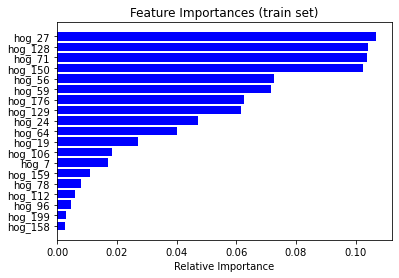

In [23]:
# get importance
importances = clf.best_estimator_[2].feature_importances_
cols = df_features.columns.values[clf.best_estimator_[1].get_support()]
indices = np.argsort(importances)[-20:-1]

plt.title('Feature Importances (train set)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

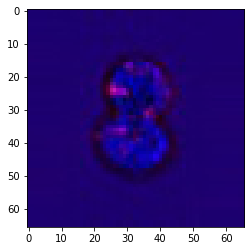

In [25]:
plt.imshow(image)

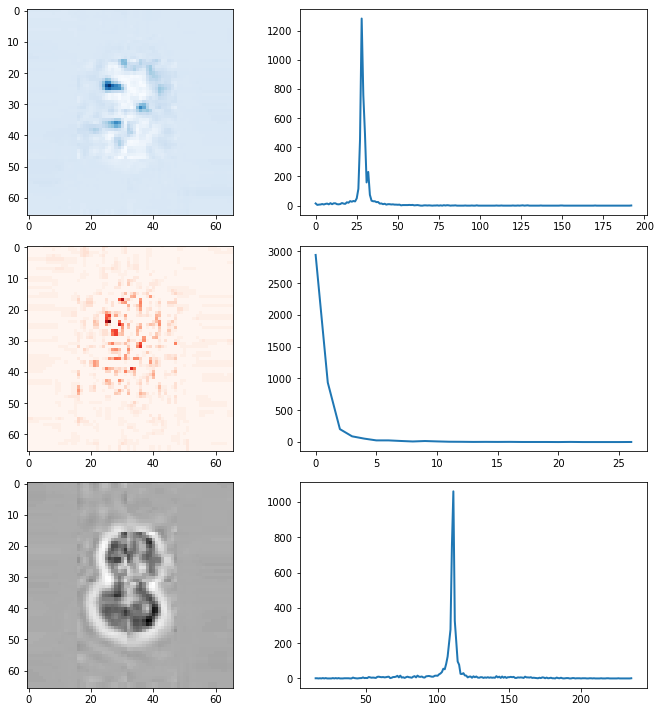

In [34]:
from skimage.exposure import histogram

hist0, hist_centers0 = histogram(image[:,:,0])
hist1, hist_centers1 = histogram(image[:,:,1])
hist2, hist_centers2 = histogram(image[:,:,2])


fig, ax = plt.subplots(nrows =3, ncols=2, figsize=(10, 10))

ax[0,0].imshow(image[:,:,0], cmap = "Blues")


ax[0,1].plot(hist_centers0, hist0, lw=2)

ax[1,0].imshow(image[:,:,1], cmap = "Reds")


ax[1,1].plot(hist_centers1, hist1, lw=2)

ax[2,0].imshow(image[:,:,2], cmap = "Greys")

ax[2,1].plot(hist_centers2, hist2, lw=2)

plt.tight_layout()

array([2959,  941,  210,   98,   65,   34,   38,   31,   18,   33,   20,
         21,   20,   12,   12,   14,   22,   15,   14,   24,   22,   33,
         29,   32,   29,   50,  116,  456, 1282,  760,  494,  161,  231,
         74,   34,   31,   31,   25,   26,   14,   15,   15,   15,    8,
         10,   11,   10,   11,   13,    9,    9,    9,   10,   10,    8,
          9,    8,    8,   13,   15,   10,   10,   12,    8,    7,    9,
         12,    4,    5,   10,    9,   10,   16,    7,   18,    5,    9,
          3,   10,   11,   10,    8,    4,   11,   14,    8,   16,   10,
          9,   11,    6,    6,   12,   13,   14,   13,   10,   10,   17,
         16,   15,   23,   28,   36,   55,   52,   83,  124,  198,  277,
        756, 1060,  326,  213,   96,   78,   26,   25,   30,   17,   17,
          6,   10,   12,    4,   13,    9,   11,    6,    6,    7,    7,
          3,    6,    4,    7,    4,    7,    4,    5,    4,   13,    6,
         10,    3,   11,    4,    9,    3,    8,   